In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score

from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Scipy library is used to conduct McNemar test
from scipy import stats

from matplotlib.ticker import MaxNLocator

# ML model interpretation libraries
import shap
from lime import lime_tabular

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from warnings import filterwarnings
filterwarnings('ignore')

# reading the data in the form of pandas dataframe object
data = pd.read_excel("data.xlsx")
raw_data = pd.read_excel("raw_data.xlsx")
df = data.copy()

## Raw Data

In [4]:
raw_data.drop(["Paper No", "Specimen"], axis=1, inplace=True)
raw_data.head()

,tw (mm),lw (mm),hw (mm),M/Vlw,P/Agfc,fc (MPa),Ab (cm2),Ab/Ag,Ag (cm2),ρbl.fybl (MPa),ρsh.fysh (MPa),ρl.fyl (MPa),ρt.fyt (MPa),v_test (kN),failure_mode
0,150.0,1000,2200.0,2.20,0.00,30.5,300.0,0.200000,150000.0,5.652500,7.395000,2.847500,3.740000,155.15,3.0
1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,0.000000,210000.0,0.000000,0.000000,4.410368,2.021229,666.82,3.0
2,150.0,1400,2000.0,1.43,0.01,46.6,0.0,0.000000,210000.0,0.000000,0.000000,7.725619,2.021229,787.40,1.0
3,127.0,1625,12000.0,7.38,0.10,49.0,771.4,0.249569,309093.0,2.956163,2.667677,1.219476,1.177428,144.75,3.0
4,100.0,700,1600.0,2.50,0.15,27.4,100.0,0.142857,70000.0,14.732880,0.000000,2.673600,2.655481,143.15,2.0


In [5]:
print(raw_data.shape)
print(raw_data.isnull().sum())

(497, 15)
tw (mm)            0
lw (mm)            0
hw (mm)            0
M/Vlw              0
P/Agfc             0
fc (MPa)           0
Ab (cm2)           0
Ab/Ag              0
Ag (cm2)           0
ρbl.fybl (MPa)     4
ρsh.fysh (MPa)    20
ρl.fyl (MPa)       0
ρt.fyt (MPa)       0
v_test (kN)       24
failure_mode       6
dtype: int64


In [6]:
raw_data.dropna(inplace=True, axis=0)
raw_data.shape

(470, 15)

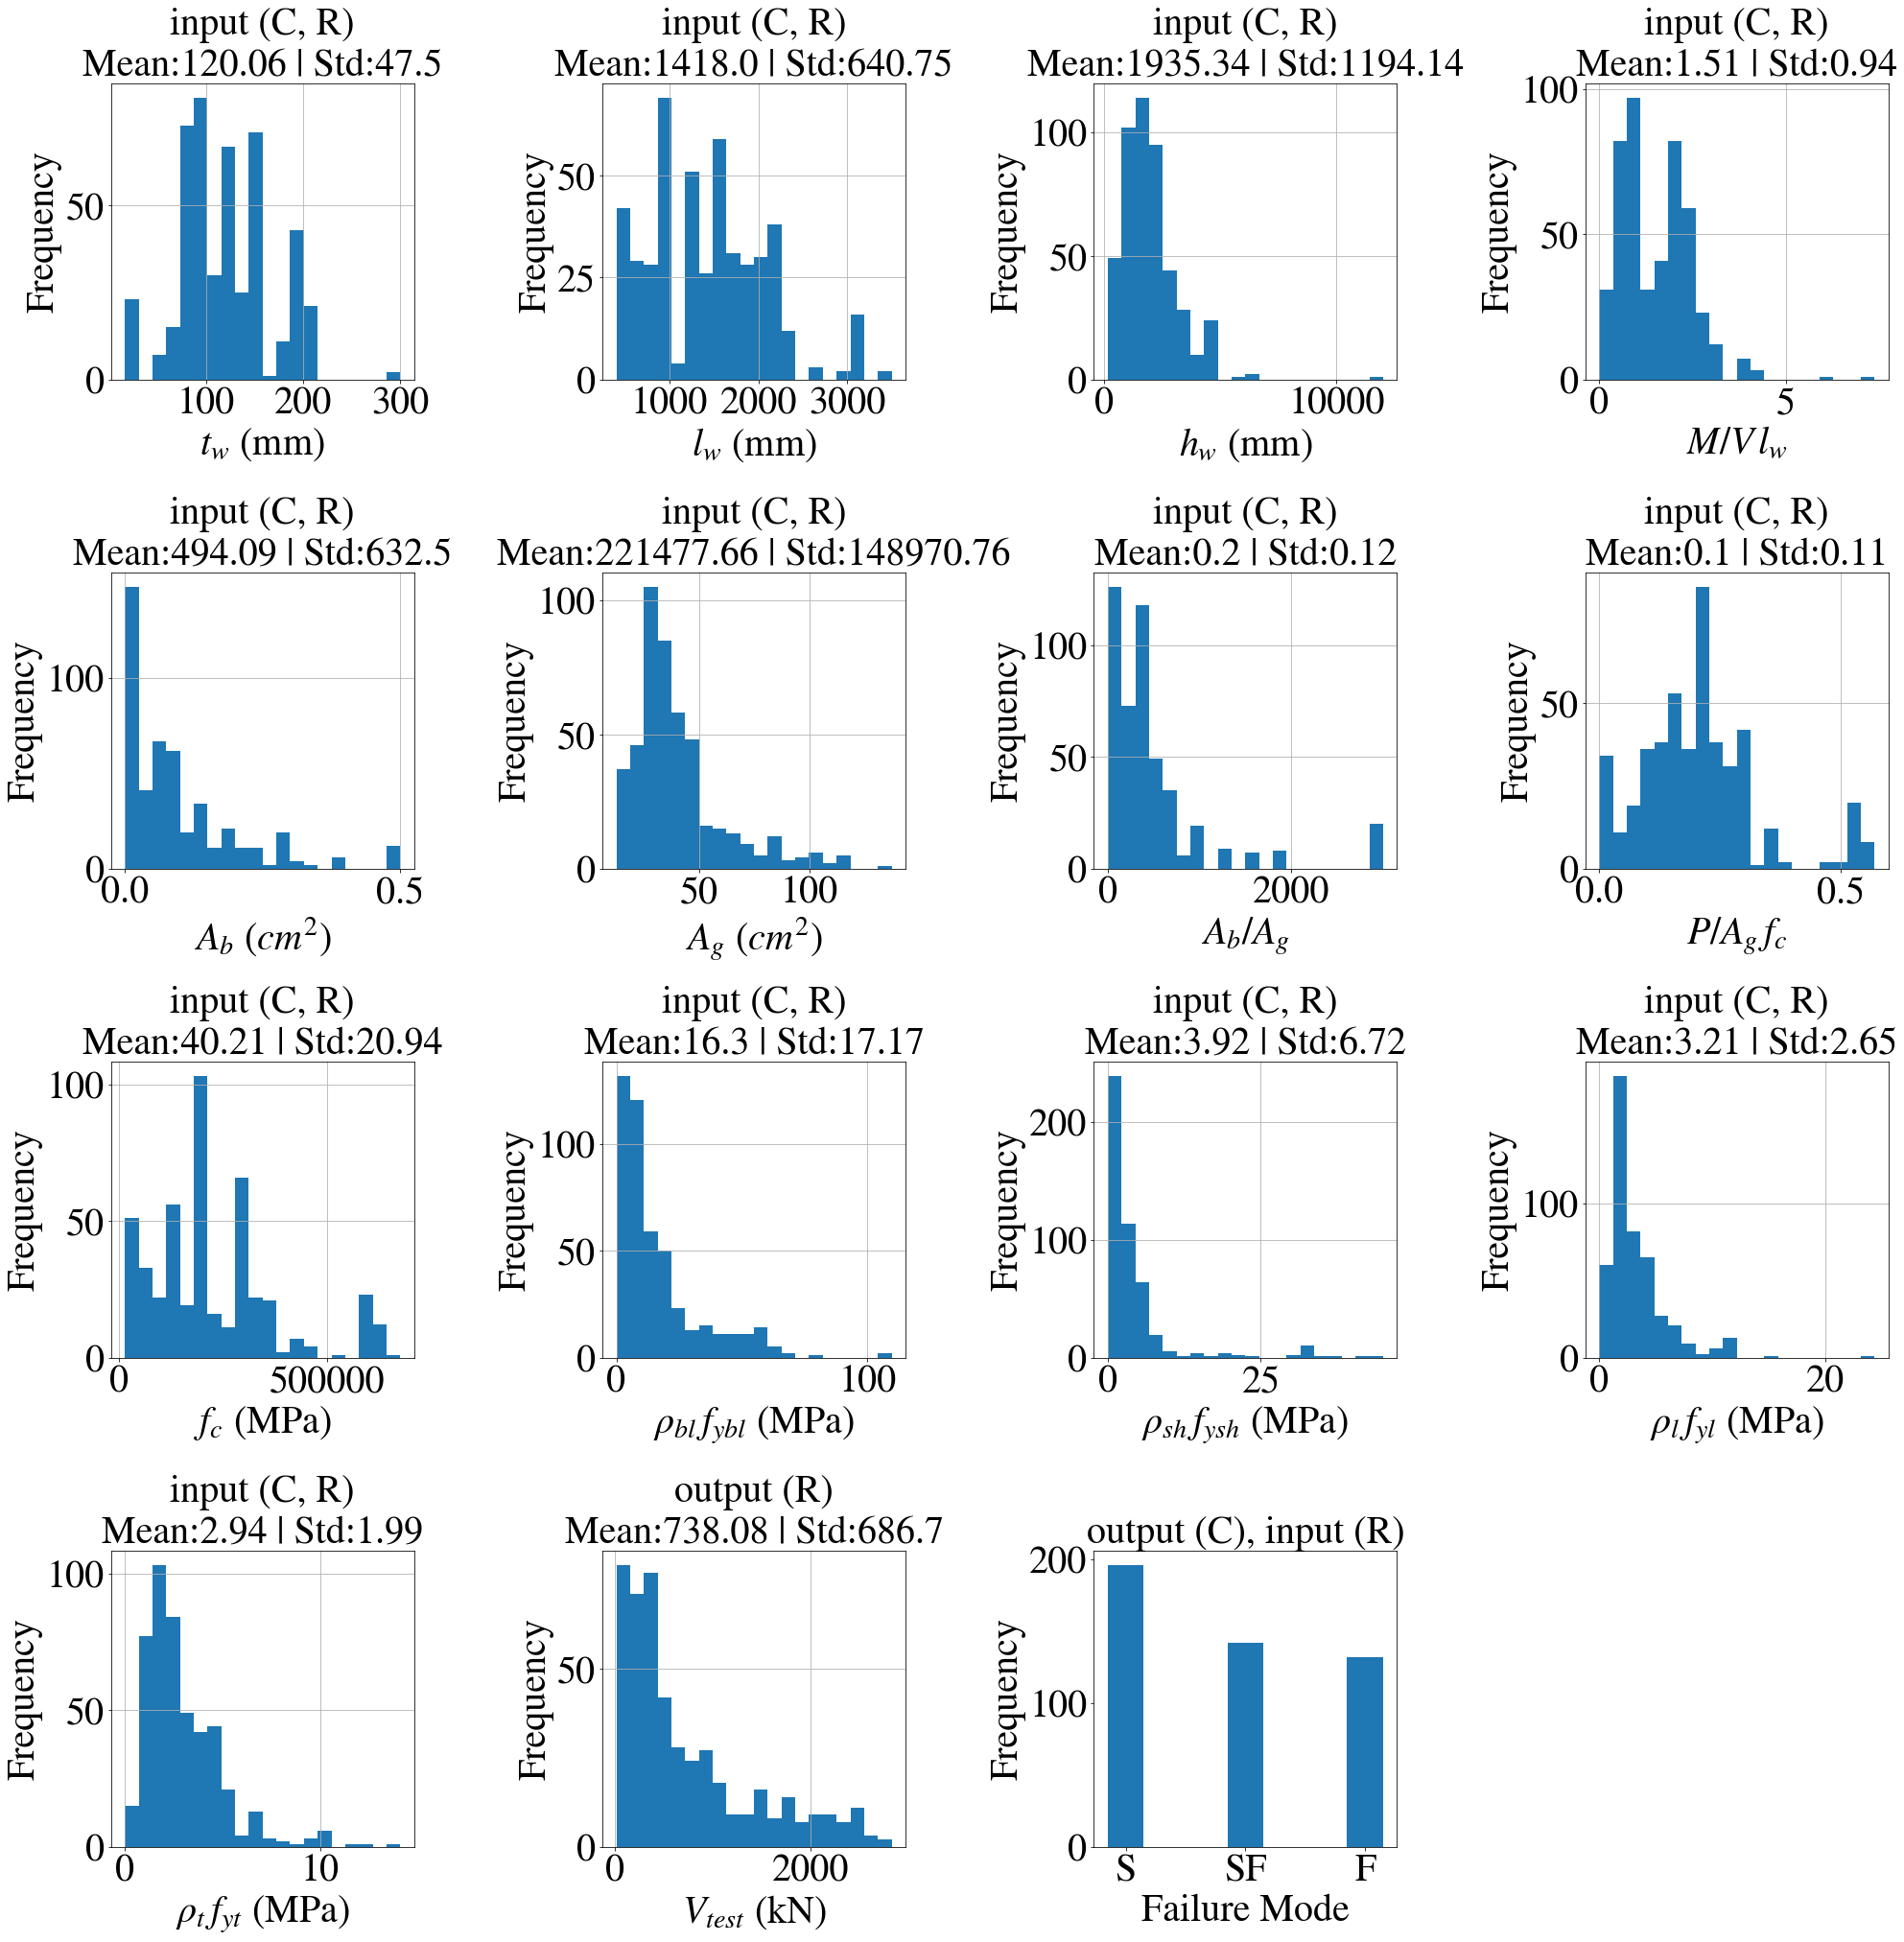

In [7]:
plt.rc('axes', labelsize=40)
plt.rc('axes', titlesize=40)
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

axes = raw_data.hist(column=raw_data.columns.to_list(), grid=True, figsize=(30,30), bins=20, layout=(4, 4))
plt.tight_layout(pad=12.0)

axes[0, 0].set_title(f"input (C, R)\nMean:{round(raw_data['tw (mm)'].mean(), 2)} | Std:{round(raw_data['tw (mm)'].std(), 2)}")
axes[0, 0].set_xlabel(r"$t_w$ (mm)")
axes[0, 0].set_ylabel("Frequency")

axes[0, 1].set_title(f"input (C, R)\nMean:{round(raw_data['lw (mm)'].mean(), 2)} | Std:{round(raw_data['lw (mm)'].std(), 2)}")
axes[0, 1].set_xlabel(r"$l_w$ (mm)")
axes[0, 1].set_ylabel("Frequency")

axes[0, 2].set_title(f"input (C, R)\nMean:{round(raw_data['hw (mm)'].mean(), 2)} | Std:{round(raw_data['hw (mm)'].std(), 2)}")
axes[0, 2].set_xlabel(r"$h_w$ (mm)")
axes[0, 2].set_ylabel("Frequency")

axes[0, 3].set_title(f"input (C, R)\nMean:{round(raw_data['M/Vlw'].mean(), 2)} | Std:{round(raw_data['M/Vlw'].std(), 2)}")
axes[0, 3].set_xlabel(r"$M/V\,l_w$")
axes[0, 3].set_ylabel("Frequency")

axes[1, 0].set_title(f"input (C, R)\nMean:{round(raw_data['Ab (cm2)'].mean(), 2)} | Std:{round(raw_data['Ab (cm2)'].std(), 2)}")
axes[1, 0].set_xlabel(r"$A_b$ $(cm^2)$")
axes[1, 0].set_ylabel("Frequency")

axes[1, 1].set_title(f"input (C, R)\nMean:{round(raw_data['Ag (cm2)'].mean(), 2)} | Std:{round(raw_data['Ag (cm2)'].std(), 2)}")
axes[1, 1].set_xlabel(r"$A_g$ $(cm^2)$")
axes[1, 1].set_ylabel("Frequency")

axes[1, 2].set_title(f"input (C, R)\nMean:{round(raw_data['Ab/Ag'].mean(), 2)} | Std:{round(raw_data['Ab/Ag'].std(), 2)}")
axes[1, 2].set_xlabel(r"$A_b/A_g$")
axes[1, 2].set_ylabel("Frequency")

axes[1, 3].set_title(f"input (C, R)\nMean:{round(raw_data['P/Agfc'].mean(), 2)} | Std:{round(raw_data['P/Agfc'].std(), 2)}")
axes[1, 3].set_xlabel(r"$P/A_{g}\,f_{c}$")
axes[1, 3].set_ylabel("Frequency")

axes[2, 0].set_title(f"input (C, R)\nMean:{round(raw_data['fc (MPa)'].mean(), 2)} | Std:{round(raw_data['fc (MPa)'].std(), 2)}")
axes[2, 0].set_xlabel(r"$f_c$ (MPa)")
axes[2, 0].set_ylabel("Frequency")

axes[2, 1].set_title(f"input (C, R)\nMean:{round(raw_data['ρbl.fybl (MPa)'].mean(), 2)} | Std:{round(raw_data['ρbl.fybl (MPa)'].std(), 2)}")
axes[2, 1].set_xlabel(r"$ρ_{bl}\,f_{ybl}$ (MPa)")
axes[2, 1].set_ylabel("Frequency")

axes[2, 2].set_title(f"input (C, R)\nMean:{round(raw_data['ρsh.fysh (MPa)'].mean(), 2)} | Std:{round(raw_data['ρsh.fysh (MPa)'].std(), 2)}")
axes[2, 2].set_xlabel(r"$ρ_{sh}\,f_{ysh}$ (MPa)")
axes[2, 2].set_ylabel("Frequency")

axes[2, 3].set_title(f"input (C, R)\nMean:{round(raw_data['ρl.fyl (MPa)'].mean(), 2)} | Std:{round(raw_data['ρl.fyl (MPa)'].std(), 2)}")
axes[2, 3].set_xlabel(r"$ρ_l\,f_{yl}$ (MPa)")
axes[2, 3].set_ylabel("Frequency")

axes[3, 0].set_title(f"input (C, R)\nMean:{round(raw_data['ρt.fyt (MPa)'].mean(), 2)} | Std:{round(raw_data['ρt.fyt (MPa)'].std(), 2)}")
axes[3, 0].set_xlabel(r"$ρ_t\,f_{yt}$ (MPa)")
axes[3, 0].set_ylabel("Frequency")

axes[3, 1].set_title(f"output (R)\nMean:{round(raw_data['v_test (kN)'].mean(), 2)} | Std:{round(raw_data['v_test (kN)'].std(), 2)}")
axes[3, 1].set_xlabel(r"$V_{test}$ (kN)")
axes[3, 1].set_ylabel("Frequency")

axes[3, 2].clear()
axes[3, 2].bar(["S", "SF", "F"], raw_data["failure_mode"].value_counts(), width=0.3)
axes[3, 2].set_title("output (C), input (R)")
axes[3, 2].set_xlabel("Failure Mode")
axes[3, 2].set_ylabel("Frequency")


plt.show()

## Data Preprocessing

In [8]:
df.head()

,Paper No,Specimen,tw,lw,hw,M/Vlw,P/Agfc,fc,Ab,Ag,Ab/Ag,ρbl.fybl,ρsh.fysh,ρl.fyl,ρt.fyt,v_test,failure_mode
0,Abdulridha & Palermo (2017),W1-SR,150.0,1000,2200.0,2.20,0.00,30.5,30000.0,150000.0,0.200000,5.652500,7.395000,2.847500,3.740000,155.15,3.0
1,[114] Adajar et al.1995,RCW1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,210000.0,0.000000,0.000000,0.000000,4.410368,2.021229,666.82,3.0
2,NaN,RCW3,150.0,1400,2000.0,1.43,0.01,46.6,0.0,210000.0,0.000000,0.000000,0.000000,7.725619,2.021229,787.40,1.0
3,"[98] Adebar,2007",High-Rise Core Wall (265),127.0,1625,12000.0,7.38,0.10,49.0,77140.0,309093.0,0.249569,2.956163,2.667677,1.219476,1.177428,144.75,3.0
4,"[26] Alarcon,2014",W1 (49),100.0,700,1600.0,2.50,0.15,27.4,10000.0,70000.0,0.142857,14.732880,0.000000,2.673600,2.655481,143.15,2.0


In [10]:
df.drop(["Paper No", "Specimen", "v_test"], axis=1, inplace=True)
df.head()

,tw,lw,hw,M/Vlw,P/Agfc,fc,Ab,Ag,Ab/Ag,ρbl.fybl,ρsh.fysh,ρl.fyl,ρt.fyt,failure_mode
0,150.0,1000,2200.0,2.20,0.00,30.5,30000.0,150000.0,0.200000,5.652500,7.395000,2.847500,3.740000,3.0
1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,210000.0,0.000000,0.000000,0.000000,4.410368,2.021229,3.0
2,150.0,1400,2000.0,1.43,0.01,46.6,0.0,210000.0,0.000000,0.000000,0.000000,7.725619,2.021229,1.0
3,127.0,1625,12000.0,7.38,0.10,49.0,77140.0,309093.0,0.249569,2.956163,2.667677,1.219476,1.177428,3.0
4,100.0,700,1600.0,2.50,0.15,27.4,10000.0,70000.0,0.142857,14.732880,0.000000,2.673600,2.655481,2.0


In [11]:
print(df.shape)
print(df.isnull().sum())

(497, 14)
tw               0
lw               0
hw               0
M/Vlw            0
P/Agfc           0
fc               0
Ab               0
Ag               0
Ab/Ag            0
ρbl.fybl         4
ρsh.fysh        20
ρl.fyl           0
ρt.fyt           0
failure_mode     6
dtype: int64


In [12]:
df.dropna(inplace=True, axis=0)
df.shape

(473, 14)

In [13]:
df.failure_mode.value_counts()

1.0    197
2.0    143
3.0    133
Name: failure_mode, dtype: int64

In [14]:
X = df.drop('failure_mode', axis=1)
y = df["failure_mode"]

In [15]:
# Scaled data is used for Logistic Regression, SVM and MLP models
cols = X.columns
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=cols)

# Performances of ML Models

In [16]:
# list of random numbers used to split the data into train and test 100 times
randomlist = random.sample(range(1, 10000), 100)

## LightGBM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

lgbm = LGBMClassifier()

lgbm_params = {'n_estimators': [100, 150, 200, 250],
               'subsample': [0.1, 0.3, 0.5, 0.7],
               'min_child_samples': [3, 5, 8],
               'max_depth': [-1, 3, 6, 9],
               'num_leaves': [10, 15, 20, 25]}
        

gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv = 5, 
                     n_jobs = -1, # -1 means using all processors
                     verbose = 2  # The higher, the more messages.
                     ).fit(X_train, y_train)

lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print("Best parameters:", gs_cv.best_params_)
print('Accuracy: %.2f%%' % (acc_score * 100))

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters: {'max_depth': -1, 'min_child_samples': 3, 'n_estimators': 150, 'num_leaves': 15, 'subsample': 0.1}
Accuracy: 83.19%


In [ ]:
lgb = LGBMClassifier(n_estimators=200, num_leaves=15, subsample=0.1, max_depth=9, min_child_samples=8)
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    lgb.fit(X_train, y_train)
    y_pred_train = lgb.predict(X_train)
    y_pred_test = lgb.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])
    feature_imp = pd.Series(lgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])


feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

Average Training Accuracy Score: 1.0
Standard Deviation of Training Accuracy Scores: 0.0
Average Testing Accuracy Score: 0.8532
Standard Deviation of Testing Accuracy Scores: 0.0338
Average Precision of S Score: 0.8961
Average Precision of SF Score: 0.8099
Average Precision of F Score: 0.836
Random state that gives the best accuracy: 6814
Random state that gives the worst accuracy: 4789


In [ ]:
df_scores_lgbm = pd.DataFrame()
df_scores_lgbm["All"] = scores["testing"]
df_scores_lgbm["S"] = scores["S"]
df_scores_lgbm["SF"] = scores["SF"]
df_scores_lgbm["F"] = scores["F"]

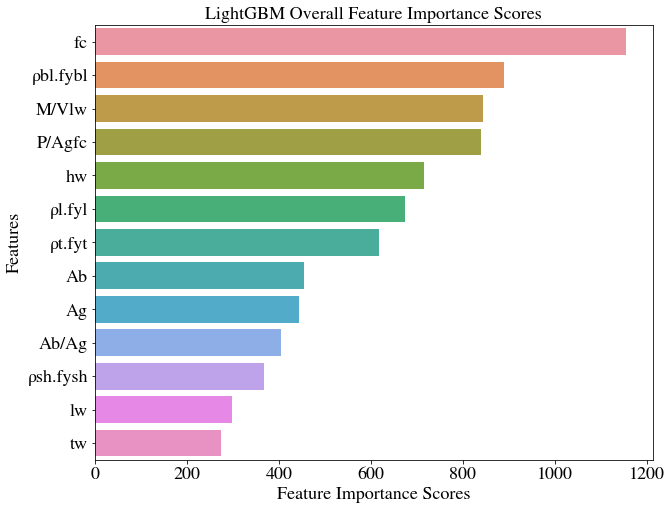

In [ ]:
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

plt.figure(figsize = (10, 8))
sns.barplot(x=feature_imp_final, y=feature_imp_final.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("LightGBM Overall Feature Importance Scores")
plt.show()

## CatBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

catb = CatBoostClassifier(silent=True)

catb_params = {'depth': [3, 4, 5, 6, 7],
               'iterations': [50, 100, 150, 200]
			   }

gs_cv = GridSearchCV(catb,
                     catb_params,
                     cv = 5, 
                     n_jobs = -1, # -1 means using all processors
                     verbose = 2  # The higher, the more messages.
                     ).fit(X_train, y_train)

catb_tuned = CatBoostClassifier(**gs_cv.best_params_, silent=True).fit(X_train, y_train)
y_pred = catb_tuned.predict(X_test)
print("Best Parameters:", gs_cv.best_params_)
print('Accuracy Ratio: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'depth': 6, 'iterations': 200}
Accuracy Ratio: 85.71%


In [18]:
catb = CatBoostClassifier(depth=5, iterations=200, silent=True)
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    catb.fit(X_train, y_train)
    y_pred_train = catb.predict(X_train)
    y_pred_test = catb.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])
    feature_imp = pd.Series(catb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final_catb = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

Average Training Accuracy Score: 1.0
Standard Deviation of Training Accuracy Scores: 0.0
Average Testing Accuracy Score: 0.8586
Standard Deviation of Testing Accuracy Scores: 0.0345
Average Precision of S Score: 0.8977
Average Precision of SF Score: 0.8191
Average Precision of F Score: 0.8449
Random state that gives the best accuracy: 6814
Random state that gives the worst accuracy: 7982


In [ ]:
df_scores_catb = pd.DataFrame()
df_scores_catb["All"] = scores["testing"]
df_scores_catb["S"] = scores["S"]
df_scores_catb["SF"] = scores["SF"]
df_scores_catb["F"] = scores["F"]

In [20]:
# feature importance scores of CatBoost method
feature_imp_final_catb

M/Vlw       23.347546
ρbl.fybl    12.683424
hw           9.360150
fc           7.243892
Ab           6.281906
P/Agfc       6.071416
ρl.fyl       5.838904
ρt.fyt       5.138609
ρsh.fysh     5.076813
Ag           4.829906
lw           4.684369
tw           4.340178
Ab/Ag        4.253683
dtype: float64

Index(['M/Vlw', 'ρbl.fybl', 'hw', 'fc', 'Ab', 'P/Agfc', 'ρl.fyl', 'ρt.fyt',
       'ρsh.fysh', 'Ag', 'lw', 'tw', 'Ab/Ag'],
      dtype='object')


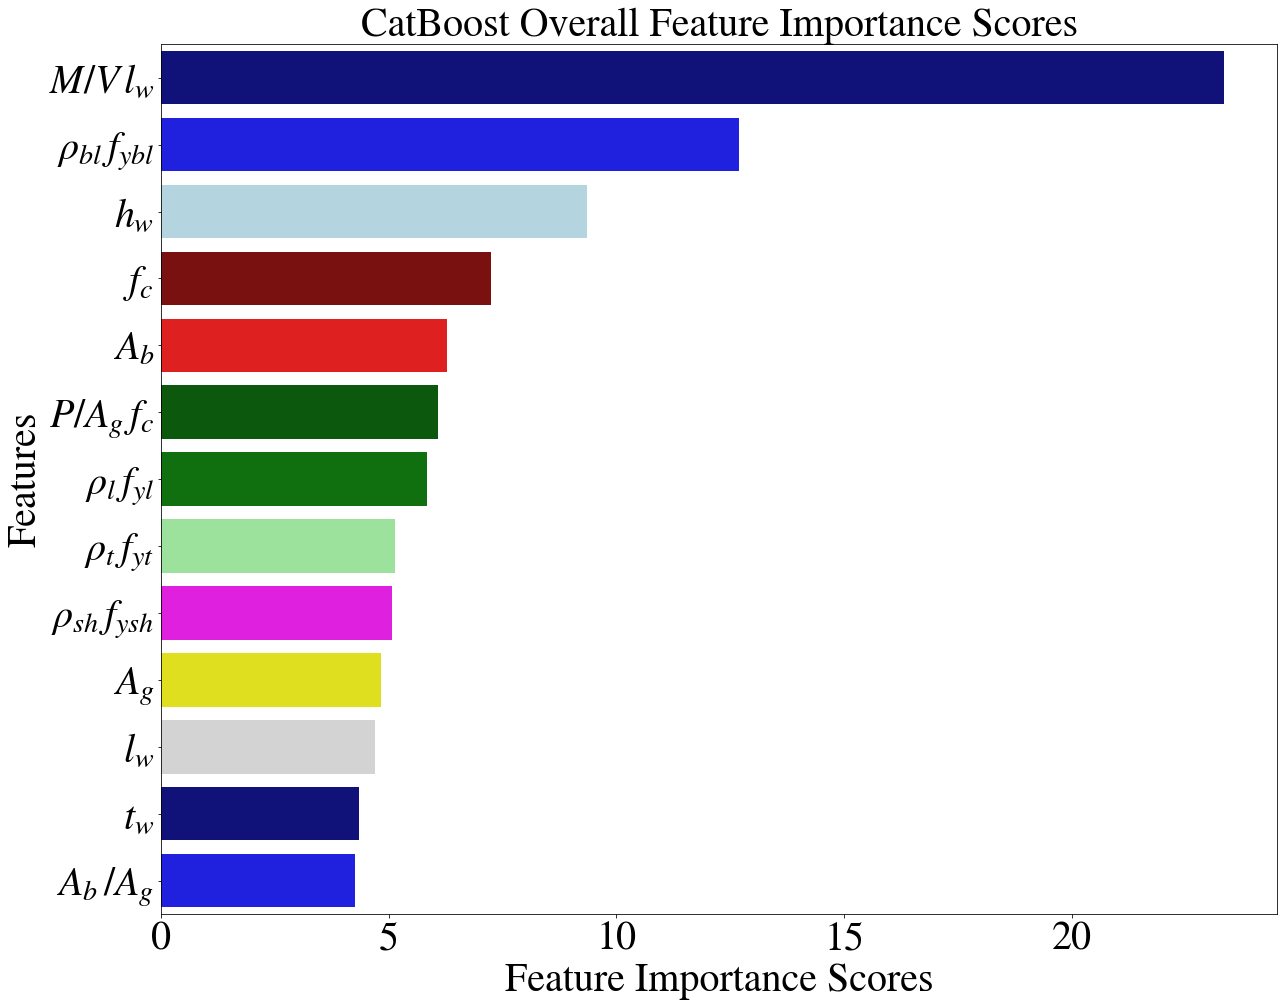

In [ ]:
colours = ["darkblue", "blue", "lightblue", "darkred", "red", "darkgreen", 
           "green", "lightgreen", "magenta", "yellow", "lightgray"]
plt.figure(figsize = (20, 16))
sns.barplot(x=feature_imp_final_catb, y=[r"$M/V\,l_w$", r"$\rho_{bl}\,f_{ybl}$", r"$h_w$", r"$f_c$", r"$A_b$", r"$P/A_g\,f_c$",
 r"$\rho_l\,f_{yl}$", r"$\rho_t\,f_{yt}$", r"$\rho_{sh}\,f_{ysh}$", r"$A_g$", r"$l_w$", r"$t_w$", r"$A_b\,/A_g$"], palette=colours)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("CatBoost Overall Feature Importance Scores")
plt.show()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7982)

catb_tuned = CatBoostClassifier(depth=5, iterations=200, silent=True).fit(X_train, y_train)

y_pred = catb_tuned.predict(X_test)
print('Accuracy based on the worst case: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Accuracy based on the worst case: 77.89%
Confusion matrix:
[[40  4  0]
 [ 4 17  2]
 [ 2  9 17]]
Classification report:
              precision    recall  f1-score   support

         1.0       0.87      0.91      0.89        44
         2.0       0.57      0.74      0.64        23
         3.0       0.89      0.61      0.72        28

    accuracy                           0.78        95
   macro avg       0.78      0.75      0.75        95
weighted avg       0.80      0.78      0.78        95



In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6814)

catb_tuned = CatBoostClassifier(depth=5, iterations=200, silent=True).fit(X_train, y_train)

y_pred = catb_tuned.predict(X_test)
print('Accuracy based on the best case: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Accuracy based on the best case: 93.68%
Confusion matrix:
[[40  0  0]
 [ 3 25  2]
 [ 0  1 24]]
Classification report:
              precision    recall  f1-score   support

         1.0       0.93      1.00      0.96        40
         2.0       0.96      0.83      0.89        30
         3.0       0.92      0.96      0.94        25

    accuracy                           0.94        95
   macro avg       0.94      0.93      0.93        95
weighted avg       0.94      0.94      0.94        95



## XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

xgb = XGBClassifier(verbosity=0)

xgb_params = {'n_estimators': [50, 100, 150, 200],
               'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
               'min_child_samples': [3, 5, 8],
               'max_depth': [-1, 3, 6, 9]
               }
        

gs_cv = GridSearchCV(xgb,
                     xgb_params,
                     cv = 5, 
                     n_jobs = -1, # -1 means using all processors
                     verbose = 2  # The higher, the more messages.
                     ).fit(X_train, y_train)

xgb_tuned = XGBClassifier(**gs_cv.best_params_, verbosity=0).fit(X_train, y_train)
y_pred = xgb_tuned.predict(X_test)
print("Best Parameters:", gs_cv.best_params_)
print('Accuracy Ratio: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))

In [ ]:
xgb = XGBClassifier(verbosity=0, colsample_bytree=0.3, min_child_samples=3, max_depth=6, n_estimators=100)
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])
    feature_imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final_xgb = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

In [ ]:
df_scores_xgb = pd.DataFrame()
df_scores_xgb["All"] = scores["testing"]
df_scores_xgb["S"] = scores["S"]
df_scores_xgb["SF"] = scores["SF"]
df_scores_xgb["F"] = scores["F"]

Index(['M/Vlw', 'Ag', 'hw', 'ρbl.fybl', 'ρsh.fysh', 'tw', 'ρt.fyt', 'Ab',
       'Ab/Ag', 'P/Agfc', 'lw', 'ρl.fyl', 'fc'],
      dtype='object')


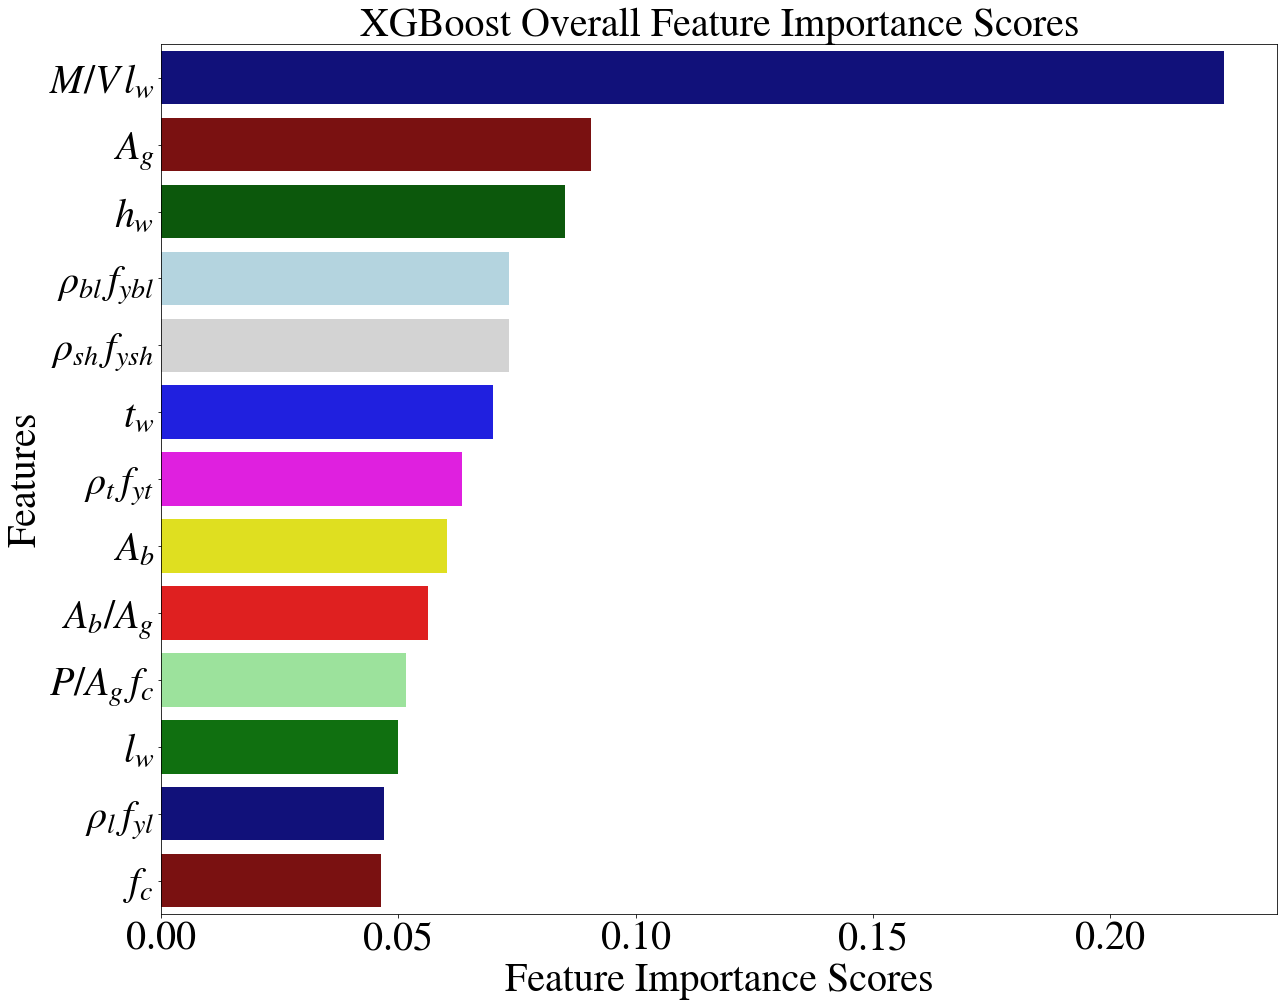

In [ ]:
colours = ["darkblue", "darkred", "darkgreen", "lightblue", "lightgray", "blue", 
           "magenta", "yellow", "red", "lightgreen", "green"]

plt.figure(figsize = (20, 16))
sns.barplot(x=feature_imp_final_xgb, y=[r"$M/V\,l_w$", r"$A_g$", r"$h_w$", r"$\rho_{bl}\,f_{ybl}$", 
                                    r"$\rho_{sh}\,f_{ysh}$", r"$t_w$", r"$\rho_t\,f_{yt}$", r"$A_b$",
                                    r"$A_b/A_g$", r"$P/A_g\,f_c$", r"$l_w$", r"$\rho_l\,f_{yl}$", r"$f_c$"], palette=colours)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("XGBoost Overall Feature Importance Scores")
plt.show()

## Support Vector Machines

In [ ]:
svm = SVC()

svm_params = {
    'C': [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
    "kernel":['linear','poly','rbf','sigmoid'],
    "gamma": ["auto", "scale"]
}

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(svm,
                    svm_params,
                    cv = 5, 
                    n_jobs = -1, # -1 means using all processors
                    verbose = 2  # The higher, the more messages.
                    ).fit(X_train, y_train)
print(f"Best Parameters: {gs_cv.best_params_}")
svm_tuned = SVC(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = svm_tuned.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy Score: 0.7789


In [ ]:
svm = SVC(C=50, gamma="scale", kernel="rbf")
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    svm.fit(X_train, y_train)
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])

Average Training Accuracy Score: 0.9799
Standard Deviation of Training Accuracy Scores: 0.005
Average Testing Accuracy Score: 0.8055
Standard Deviation of Testing Accuracy Scores: 0.0351
Average Precision of S Score: 0.8583
Average Precision of SF Score: 0.7465
Average Precision of F Score: 0.7945
Random state that gives the best accuracy: 8866
Random state that gives the worst accuracy: 4832


In [ ]:
df_scores_svm = pd.DataFrame()
df_scores_svm["All"] = scores["testing"]
df_scores_svm["S"] = scores["S"]
df_scores_svm["SF"] = scores["SF"]
df_scores_svm["F"] = scores["F"]

## Multi Layer Perceptron

In [ ]:
mlp = MLPClassifier()

mlp_params = {"alpha": [1, 0.1, 0.01, 0.001],
              "hidden_layer_sizes": [(5, 5),
                                     (10, 10), 
                                     (10, 10, 10)],
              "solver" : ["lbfgs","adam","sgd"], 
              "activation": ["tanh","logistic", "relu"]}

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(mlp,
                     mlp_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2 
                     ).fit(X_train, y_train)
print(f"Best Params: {gs_cv.best_params_}")
mlp_tuned = MLPClassifier(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = mlp_tuned.predict(X_test)
    
score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [ ]:
mlp = MLPClassifier(activation="tanh", alpha=0.1, solver="lbfgs", hidden_layer_sizes=(10,10))
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    mlp.fit(X_train, y_train)
    y_pred_train = mlp.predict(X_train)
    y_pred_test = mlp.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])

Average Training Accuracy Score: 0.9996
Standard Deviation of Training Accuracy Scores: 0.0011
Average Testing Accuracy Score: 0.7911
Standard Deviation of Testing Accuracy Scores: 0.0388
Average Precision of S Score: 0.8817
Average Precision of SF Score: 0.7045
Average Precision of F Score: 0.7551
Random state that gives the best accuracy: 946
Random state that gives the worst accuracy: 6235


In [ ]:
df_scores_mlp = pd.DataFrame()
df_scores_mlp["All"] = scores["testing"]
df_scores_mlp["S"] = scores["S"]
df_scores_mlp["SF"] = scores["SF"]
df_scores_mlp["F"] = scores["F"]

## Random Forests

In [ ]:
rf = RandomForestClassifier()

rf_params = {"max_depth": [3, 6, 8, 10],
            "max_features": [2, 5, 8],
            "n_estimators": [50, 100, 150, 200], 
            "min_samples_split": [2, 5, 8, 10]}  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gs_cv = GridSearchCV(rf,
                     rf_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2  
                     ).fit(X_train, y_train)
print(f"Best Params: {gs_cv.best_params_}")
rf_tuned = RandomForestClassifier(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [ ]:
rf = RandomForestClassifier(max_depth=10, max_features=8, min_samples_split=2, n_estimators=100)
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])
    feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    feature_imp_scores = pd.concat([feature_imp_scores, feature_imp], axis=1) 

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])

feature_imp_scores["std"] = feature_imp_scores.std(axis=1)
feature_imp_scores["mean"] = feature_imp_scores.mean(axis=1)
feature_imp_scores = feature_imp_scores.sort_values(by=["mean"], ascending=False)
feature_imp_final = pd.Series(feature_imp_scores["mean"].values, feature_imp_scores.index).sort_values(ascending=False)

Average Training Accuracy Score: 0.9998
Standard Deviation of Training Accuracy Scores: 0.0006
Average Testing Accuracy Score: 0.8495
Standard Deviation of Testing Accuracy Scores: 0.0355
Average Precision of S Score: 0.8958
Average Precision of SF Score: 0.8008
Average Precision of F Score: 0.8347
Random state that gives the best accuracy: 1220
Random state that gives the worst accuracy: 4832


In [ ]:
df_scores_rf = pd.DataFrame()
df_scores_rf["All"] = scores["testing"]
df_scores_rf["S"] = scores["S"]
df_scores_rf["SF"] = scores["SF"]
df_scores_rf["F"] = scores["F"]

## Logistic Regression

In [ ]:
lr = LogisticRegression()

lr_params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            "penalty": ["l1", "l2", "elasticnet", "none"]
            }

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(lr,
                     lr_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2 
                     ).fit(X_train, y_train)
print(f"Best Params: {gs_cv.best_params_}")   
lr_tuned = LogisticRegression(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = lr_tuned.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [ ]:
lr = LogisticRegression(C=100, penalty="l1", solver="saga")
scores = {"training": [], "testing": [], "S": [], "SF": [], "F": []}
feature_imp_scores = pd.DataFrame()

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    train_acc_score = accuracy_score(y_train, y_pred_train)
    test_acc_score = accuracy_score(y_test, y_pred_test)
    scores["training"].append(train_acc_score)
    scores["testing"].append(test_acc_score)
    scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
    scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
    scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])

print(f"Average Training Accuracy Score: {round(np.mean(scores['training']), 4)}")
print(f"Standard Deviation of Training Accuracy Scores: {round(np.std(scores['training']), 4)}")
print(f"Average Testing Accuracy Score: {round(np.mean(scores['testing']), 4)}")
print(f"Standard Deviation of Testing Accuracy Scores: {round(np.std(scores['testing']), 4)}")

print(f"Average Precision of S Score: {round(np.mean(scores['S']), 4)}")
print(f"Average Precision of SF Score: {round(np.mean(scores['SF']), 4)}")
print(f"Average Precision of F Score: {round(np.mean(scores['F']), 4)}")

print("Random state that gives the best accuracy:", randomlist[np.argmax(scores["testing"])])
print("Random state that gives the worst accuracy:", randomlist[np.argmin(scores["testing"])])

Average Training Accuracy Score: 0.742
Standard Deviation of Training Accuracy Scores: 0.0138
Average Testing Accuracy Score: 0.7052
Standard Deviation of Testing Accuracy Scores: 0.0402
Average Precision of S Score: 0.8093
Average Precision of SF Score: 0.5497
Average Precision of F Score: 0.6933
Random state that gives the best accuracy: 7837
Random state that gives the worst accuracy: 6169


In [ ]:
df_scores_lr = pd.DataFrame()
df_scores_lr["All"] = scores["testing"]
df_scores_lr["S"] = scores["S"]
df_scores_lr["SF"] = scores["SF"]
df_scores_lr["F"] = scores["F"]

## Overall Evaluation

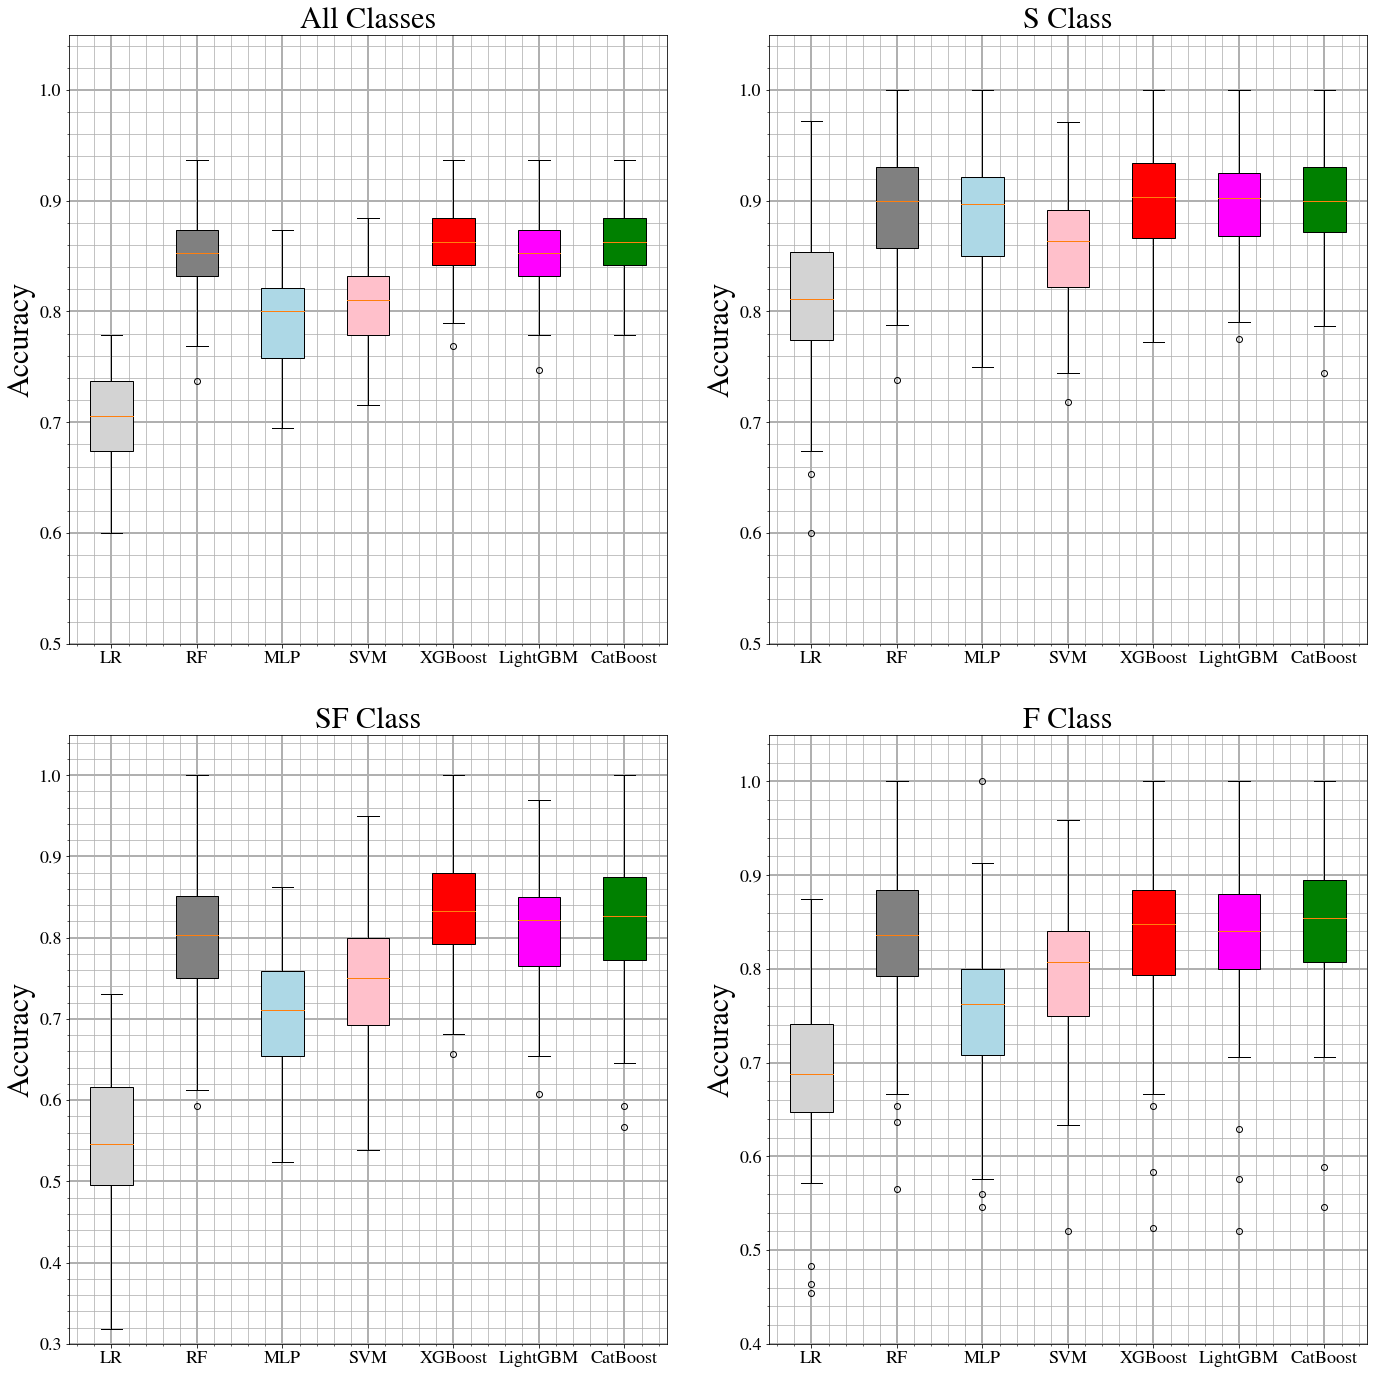

In [ ]:
plt.rc('axes', labelsize=30)
plt.rc('axes', titlesize=30)
plt.rc('xtick', labelsize=18)  
plt.rc('ytick', labelsize=18)    

all_dict = {'LR': df_scores_lr["All"].values, 'RF': df_scores_rf["All"].values,
           'MLP': df_scores_mlp["All"].values, 'SVM': df_scores_svm["All"].values,
           'XGBoost': df_scores_xgb["All"].values, 'LightGBM': df_scores_lgbm["All"].values,
           'CatBoost': df_scores_catb["All"].values,
           }

s_dict = {'LR': df_scores_lr["S"].values, 'RF': df_scores_rf["S"].values,
           'MLP': df_scores_mlp["S"].values, 'SVM': df_scores_svm["S"].values,
           'XGBoost': df_scores_xgb["S"].values, 'LightGBM': df_scores_lgbm["S"].values,
           'CatBoost': df_scores_catb["S"].values,
           }

sf_dict = {'LR': df_scores_lr["SF"].values, 'RF': df_scores_rf["SF"].values,
           'MLP': df_scores_mlp["SF"].values, 'SVM': df_scores_svm["SF"].values,
           'XGBoost': df_scores_xgb["SF"].values, 'LightGBM': df_scores_lgbm["SF"].values,
           'CatBoost': df_scores_catb["SF"].values,
           }

f_dict = {'LR': df_scores_lr["F"].values, 'RF': df_scores_rf["F"].values,
           'MLP': df_scores_mlp["F"].values, 'SVM': df_scores_svm["F"].values,
           'XGBoost': df_scores_xgb["F"].values, 'LightGBM': df_scores_lgbm["F"].values,
           'CatBoost': df_scores_catb["F"].values,
           }

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

colours = ["lightgray", "gray", "lightblue", "pink", "red", "magenta", "green"]

axs[0, 0].set_title("All Classes")
bplot1 = axs[0, 0].boxplot(all_dict.values(), patch_artist=True)
axs[0, 0].set_xticklabels(all_dict.keys())
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].set_ylim([0.5, 1.05])
axs[0, 0].grid(which="minor", linewidth=0.75)
axs[0, 0].grid(which="major", linewidth=2)
axs[0, 0].minorticks_on()
for patch, color in zip(bplot1['boxes'], colours):
    patch.set_facecolor(color)

axs[0, 1].set_title("S Class")
bplot2 = axs[0, 1].boxplot(s_dict.values(), patch_artist=True)
axs[0, 1].set_xticklabels(s_dict.keys())
axs[0, 1].set_ylabel("Accuracy")
axs[0, 1].set_ylim([0.5, 1.05])
axs[0, 1].grid(which="minor", linewidth=0.75)
axs[0, 1].grid(which="major", linewidth=2)
axs[0, 1].minorticks_on()
for patch, color in zip(bplot2['boxes'], colours):
    patch.set_facecolor(color)

axs[1, 0].set_title("SF Class")
bplot3 = axs[1, 0].boxplot(sf_dict.values(), patch_artist=True)
axs[1, 0].set_xticklabels(sf_dict.keys())
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_ylim([0.3, 1.05])
axs[1, 0].grid(which="minor", linewidth=0.75)
axs[1, 0].grid(which="major", linewidth=2)
axs[1, 0].minorticks_on()
for patch, color in zip(bplot3['boxes'], colours):
    patch.set_facecolor(color)

axs[1, 1].set_title("F Class")
bplot4 = axs[1, 1].boxplot(f_dict.values(), patch_artist=True)
axs[1, 1].set_xticklabels(f_dict.keys())
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].set_ylim([0.4, 1.05])
axs[1, 1].grid(which="minor", linewidth=0.75)
axs[1, 1].grid(which="major", linewidth=2)
axs[1, 1].minorticks_on()
for patch, color in zip(bplot4['boxes'], colours):
    patch.set_facecolor(color)

plt.tight_layout(pad=4)

plt.show()

## McNemar Test

### McNemar Test for Tree-based Models

In [ ]:
lgb = LGBMClassifier(n_estimators=200, num_leaves=15, subsample=0.1, max_depth=9, min_child_samples=8)
catb = CatBoostClassifier(depth=5, iterations=200, silent=True)
xgb = XGBClassifier(verbosity=0, colsample_bytree=0.3, min_child_samples=3, max_depth=6, n_estimators=100)
rf = RandomForestClassifier(max_depth=10, max_features=8, min_samples_split=2, n_estimators=100)

lgb_preds = np.empty([0])
catb_preds = np.empty([0])
xgb_preds = np.empty([0])
rf_preds = np.empty([0])


for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)

    lgb.fit(X_train, y_train)
    catb.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    
    y_pred_lgb = lgb.predict(X_test)
    y_pred_catb = catb.predict(X_test)
    y_pred_xgb = xgb.predict(X_test)
    y_pred_rf = rf.predict(X_test)

    lgb_preds = np.concatenate((lgb_preds, (y_pred_lgb==y_test).values), axis=0)
    catb_preds= np.concatenate((catb_preds, (y_pred_catb.T[0]==y_test).values), axis=0)
    xgb_preds = np.concatenate((xgb_preds, (y_pred_xgb==y_test).values), axis=0)
    rf_preds = np.concatenate((rf_preds, (y_pred_rf==y_test).values), axis=0)

In [ ]:
cm = confusion_matrix(lgb_preds, catb_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis rejected
There is significant difference - p value : 0.021812239256131405


In [ ]:
cm = confusion_matrix(lgb_preds, xgb_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis rejected
There is significant difference - p value : 0.014392594465857389


In [ ]:
cm = confusion_matrix(lgb_preds, rf_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis can not be rejected
There is not significant difference - p value : 0.32959331873471087


In [ ]:
cm = confusion_matrix(xgb_preds, catb_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis can not be rejected
There is not significant difference - p value : 0.9649879987482263


In [ ]:
cm = confusion_matrix(xgb_preds, rf_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis rejected
There is significant difference - p value : 0.001036929765066641


In [ ]:
cm = confusion_matrix(catb_preds, rf_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis rejected
There is significant difference - p value : 0.000920513128357392


### McNemar Test for SVM and MLP methods

In [ ]:
svm = SVC(C=50, gamma="scale", kernel="rbf")
mlp = MLPClassifier(activation="tanh", alpha=0.1, solver="lbfgs", hidden_layer_sizes=(10,10))

svm_preds = np.empty([0])
mlp_preds = np.empty([0])

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)

    svm.fit(X_train, y_train)
    mlp.fit(X_train, y_train)
   
    y_pred_svm = svm.predict(X_test)
    y_pred_mlp = mlp.predict(X_test)

    svm_preds = np.concatenate((svm_preds, (y_pred_svm==y_test).values), axis=0)
    mlp_preds = np.concatenate((mlp_preds, (y_pred_mlp==y_test).values), axis=0)

In [ ]:
cm = confusion_matrix(svm_preds, mlp_preds)
# McNemars Statistic 
MCStatistic = ((cm[0,1] - cm[1,0])**2 )/ (cm[0,1] + cm[1,0])

# Degree of freedom (n-1)*(k-1)
degreOfFreedom = (len(cm[0])-1) * (len(cm[1])-1)

# Obtain p-value from Chi-Sqaure Distribution
# You can use both method to obtain p value from chi-square distribution
r1 = 1- stats.chi2.cdf(MCStatistic , degreOfFreedom)
r2 = stats.distributions.chi2.sf(MCStatistic , degreOfFreedom)

if r1 > 0.05:
    print('Null hypothesis can not be rejected')
    print('There is not significant difference - p value :' , r1)
else:
    print('Null hypothesis rejected')
    print('There is significant difference - p value :' , r1)

Null hypothesis rejected
There is significant difference - p value : 2.298987333171354e-06


## Feature Selection for CatBoost and XGBoost Methods

In [ ]:
acc_scores_catb = {"all": [0.8586], "S": [0.8977], "SF": [0.8191], "F": [0.8449]}
selected_features = []
Z = X.copy()

catb_sel = CatBoostClassifier(depth=5, iterations=200, silent=True)

for j in range(len(Z.columns)-1):

    Z.drop(feature_imp_final_catb.index[-(j+1)], axis=1, inplace=True)
    selected_features.append(Z.columns.to_list())
    scores = {"all": [], "S": [], "SF": [], "F": []}

    for i in randomlist:
        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=i)
        catb_sel.fit(Z_train, y_train)
        y_pred_test = catb_sel.predict(Z_test)
        scores["all"].append(accuracy_score(y_test, y_pred_test))
        scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
        scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
        scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])

    acc_scores_catb["all"].append(np.mean(scores['all']))
    acc_scores_catb["S"].append(np.mean(scores['S']))
    acc_scores_catb["SF"].append(np.mean(scores['SF']))
    acc_scores_catb["F"].append(np.mean(scores['F']))

In [ ]:
acc_scores_xgb = {"all": [0.8587], "S": [0.8987], "SF": [0.83], "F": [0.8336]}
selected_features = []
Z = X.copy()

xgb_sel = XGBClassifier(verbosity=0, colsample_bytree=0.3, min_child_samples=3, max_depth=6, n_estimators=100)

for j in range(len(Z.columns)-1):

    Z.drop(feature_imp_final.index[-(j+1)], axis=1, inplace=True)
    selected_features.append(Z.columns.to_list())
    scores = {"all": [], "S": [], "SF": [], "F": []}

    for i in randomlist:
        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=i)
        xgb_sel.fit(Z_train, y_train)
        y_pred_test = xgb_sel.predict(Z_test)
        scores["all"].append(accuracy_score(y_test, y_pred_test))
        scores["S"].append(precision_score(y_test, y_pred_test, average=None)[0])
        scores["SF"].append(precision_score(y_test, y_pred_test, average=None)[1])
        scores["F"].append(precision_score(y_test, y_pred_test, average=None)[2])

    acc_scores_xgb["all"].append(np.mean(scores['all']))
    acc_scores_xgb["S"].append(np.mean(scores['S']))
    acc_scores_xgb["SF"].append(np.mean(scores['SF']))
    acc_scores_xgb["F"].append(np.mean(scores['F']))

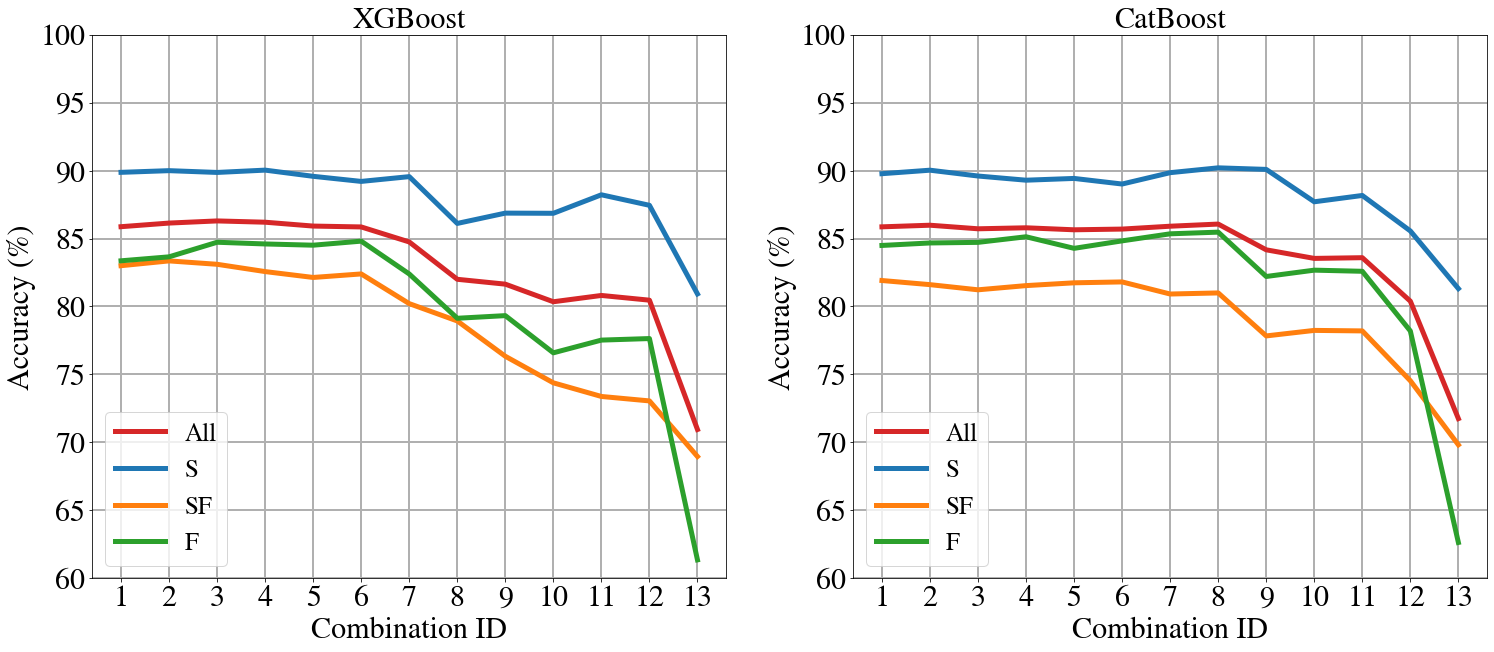

In [ ]:
ID = np.arange(1, 14, 1)

plt.rc('axes', labelsize=30)
plt.rc('axes', titlesize=30)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)  

fig, axs = plt.subplots(1, 2, figsize=(25, 10))

axs[0].plot(ID, np.array(acc_scores_xgb["all"])*100, color="tab:red", linewidth=5)
axs[0].plot(ID, np.array(acc_scores_xgb["S"])*100, color="tab:blue", linewidth=5)
axs[0].plot(ID, np.array(acc_scores_xgb["SF"])*100, color="tab:orange", linewidth=5)
axs[0].plot(ID, np.array(acc_scores_xgb["F"])*100, color="tab:green", linewidth=5)
axs[0].legend(["All", "S", "SF", "F"], fontsize=25)
axs[0].grid(which="major", linewidth=2)
axs[0].set_ylim([60, 100])
axs[0].set_xticklabels(np.arange(0, 14, 1))
axs[0].xaxis.set_major_locator(MaxNLocator(14)) 
axs[0].set_xlabel('Combination ID')
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("XGBoost")


axs[1].plot(ID, np.array(acc_scores_catb["all"])*100, color="tab:red", linewidth=5)
axs[1].plot(ID, np.array(acc_scores_catb["S"])*100, color="tab:blue", linewidth=5)
axs[1].plot(ID, np.array(acc_scores_catb["SF"])*100, color="tab:orange", linewidth=5)
axs[1].plot(ID, np.array(acc_scores_catb["F"])*100, color="tab:green", linewidth=5)
axs[1].legend(["All", "S", "SF", "F"], fontsize=25)
axs[1].grid(which="major", linewidth=2)
axs[1].set_ylim([60, 100])
axs[1].set_xticklabels(np.arange(0, 14, 1))
axs[1].xaxis.set_major_locator(MaxNLocator(14)) 
axs[1].set_xlabel('Combination ID')
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_title("CatBoost")

plt.show()

## CatBoost model with 6 features:

In [45]:
X_new = X[["M/Vlw", "ρbl.fybl", "hw", "fc", "Ab", "P/Agfc"]]
X_new.head()

,M/Vlw,ρbl.fybl,hw,fc,Ab,P/Agfc
0,2.20,5.652500,2200.0,30.5,30000.0,0.00
1,1.43,0.000000,2000.0,46.8,0.0,0.01
2,1.43,0.000000,2000.0,46.6,0.0,0.01
3,7.38,2.956163,12000.0,49.0,77140.0,0.10
4,2.50,14.732880,1600.0,27.4,10000.0,0.15


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=7982)

catb_tuned = CatBoostClassifier(depth=5, iterations=200, silent=True).fit(X_train, y_train)

y_pred = catb_tuned.predict(X_test)
print('Accuracy based on the worst case: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Accuracy based on the worst case: 80.00%
Confusion matrix:
[[41  3  0]
 [ 4 17  2]
 [ 4  6 18]]
Classification report:
              precision    recall  f1-score   support

         1.0       0.84      0.93      0.88        44
         2.0       0.65      0.74      0.69        23
         3.0       0.90      0.64      0.75        28

    accuracy                           0.80        95
   macro avg       0.80      0.77      0.78        95
weighted avg       0.81      0.80      0.80        95



In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=6814)

catb_tuned = CatBoostClassifier(depth=5, iterations=200, silent=True).fit(X_train, y_train)

y_pred = catb_tuned.predict(X_test)
print('Accuracy based on the best case: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_pred)}")

Accuracy based on the best case: 92.63%
Confusion matrix:
[[38  2  0]
 [ 1 28  1]
 [ 1  2 22]]
Classification report:
              precision    recall  f1-score   support

         1.0       0.95      0.95      0.95        40
         2.0       0.88      0.93      0.90        30
         3.0       0.96      0.88      0.92        25

    accuracy                           0.93        95
   macro avg       0.93      0.92      0.92        95
weighted avg       0.93      0.93      0.93        95



## Interpretation of CatBoost Model with 6 Features

### Interpretation with LIME

In [51]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns,
    verbose=True,
    class_names=['V/Ag(MPa)'],
    mode='regression'
)

# application of lime:
lime_r2_scores = []
for i in range(len(y_test)):
    exp = explainer.explain_instance(data_row=X_test.iloc[i], num_features=11, 
                                    predict_fn=catb_tuned.predict, )
    lime_r2_scores.append(exp.score)

Intercept 2.068394948263636
Prediction_local [1.28464324]
Right: 1.0
Intercept 2.175793963756511
Prediction_local [1.00493564]
Right: 1.0
Intercept 1.9083306946687255
Prediction_local [1.7719492]
Right: 2.0
Intercept 2.3694091038872216
Prediction_local [0.36600633]
Right: 2.0
Intercept 1.663911463492713
Prediction_local [2.4366996]
Right: 2.0
Intercept 1.6368200805909263
Prediction_local [2.42519624]
Right: 2.0
Intercept 1.6664548335193898
Prediction_local [2.37066454]
Right: 2.0
Intercept 2.0849650013301937
Prediction_local [1.35701422]
Right: 1.0
Intercept 1.5488944602120243
Prediction_local [2.84176783]
Right: 3.0
Intercept 2.0548348583482063
Prediction_local [1.32362755]
Right: 2.0
Intercept 1.8709301992877148
Prediction_local [1.81178469]
Right: 2.0
Intercept 1.5630966102442605
Prediction_local [2.76079236]
Right: 3.0
Intercept 2.0736639685416
Prediction_local [1.28326074]
Right: 1.0
Intercept 1.583095125995841
Prediction_local [2.67071892]
Right: 3.0
Intercept 2.3055493790888932


In [52]:
print(np.mean(lime_r2_scores))
print(np.std(lime_r2_scores))

0.2136946847776095
0.09991140015832346


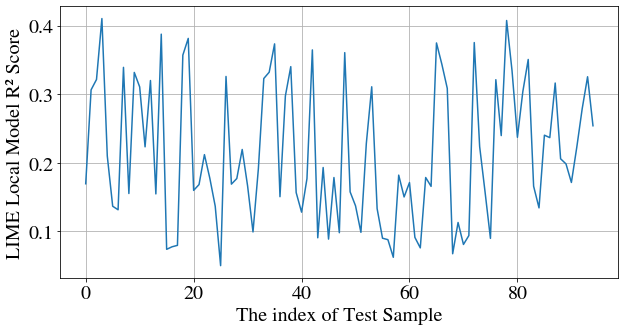

In [53]:
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

y_r2 = np.array(lime_r2_scores)
x_r2 = np.arange(len(lime_r2_scores))
plt.figure(figsize=(10,5))
plt.plot(x_r2, y_r2)
plt.xlabel("The index of Test Sample")
plt.ylabel("LIME Local Model R\u00b2 Score")
plt.grid('major')
plt.show()

## Interpretation with SHAP

In [54]:
X_new.columns

Index(['M/Vlw', 'ρbl.fybl', 'hw', 'fc', 'Ab', 'P/Agfc'], dtype='object')

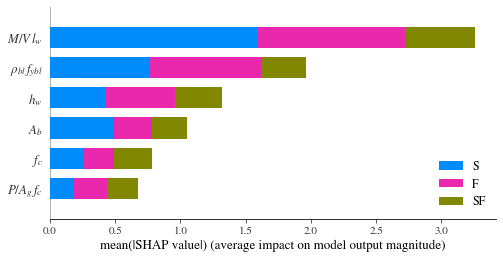

In [58]:
names=[r"$M/V\,l_w$", r"$\rho_{bl}\,f_{ybl}$",  r"$h_w$",  r"$f_c$", r"$A_b$", r"$P/A_{g}\,f_{c}$"]

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


explainer = shap.TreeExplainer(catb_tuned)
shap_values = explainer.shap_values(X_new)
shap.summary_plot(shap_values, X_new, plot_type="bar", class_names=["S", "SF", "F"], feature_names=names)

#shap.summary_plot(shap_values, X_new, plot_type="bar", class_names=["S", "SF", "F"], show=False, feature_names=names)
#plt.savefig('filename.png')
#plt.savefig('filename.png', dpi=800)

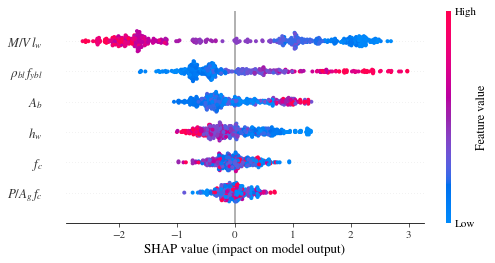

In [59]:
# Effects of features on shear failure prediction
shap_values = explainer.shap_values(X_new)
shap.summary_plot(shap_values[0], X_new, feature_names=names)

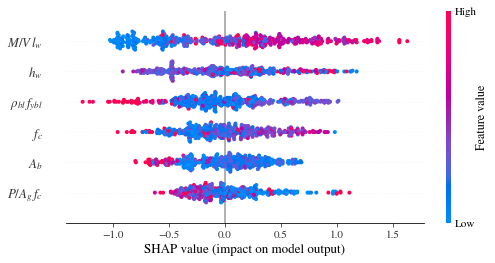

In [60]:
# Effects of features on shear-flexure failure
shap.summary_plot(shap_values[1], X_new, feature_names=names)

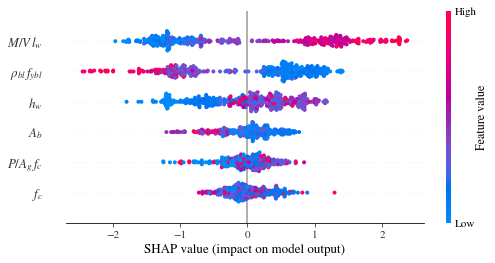

In [61]:
# Effects of features on flexure failure
shap.summary_plot(shap_values[2], X_new, feature_names=names)

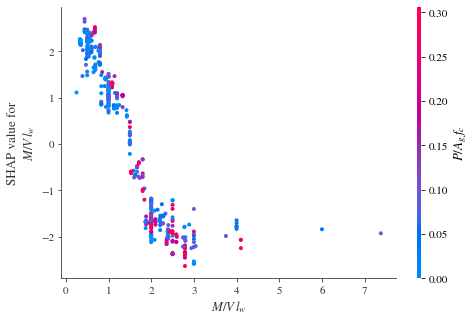

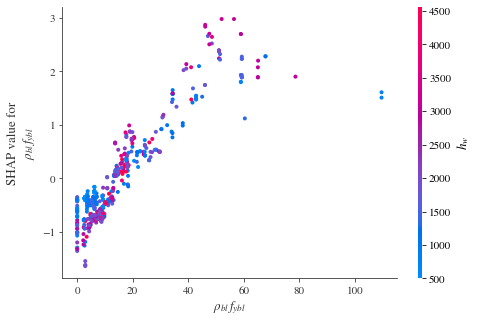

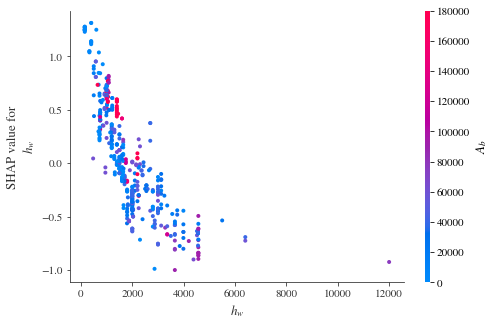

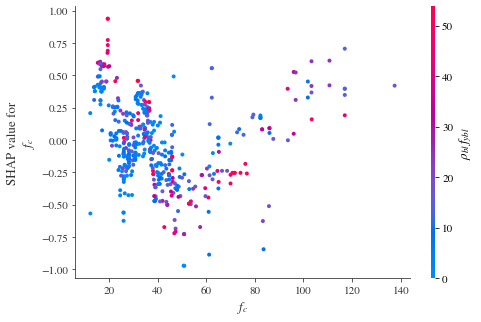

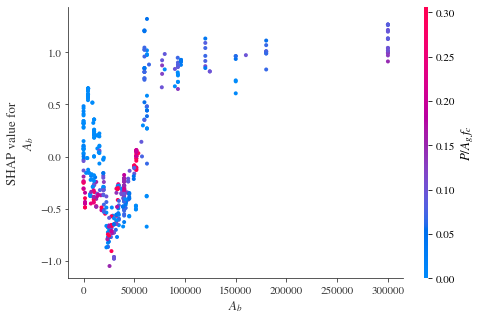

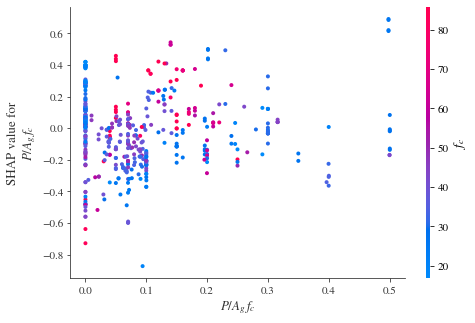

In [62]:
# Dependence plots of the features with respect to shear failure
for i in range(len(X_new.columns)):
    shap.dependence_plot(ind=i, shap_values=shap_values[0], features=X_new, feature_names=names,)

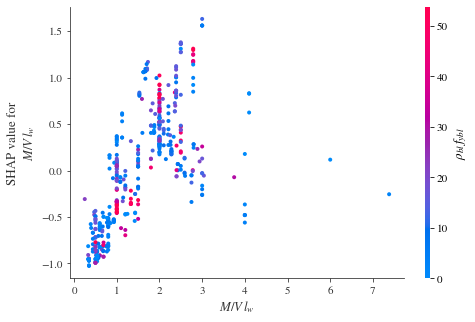

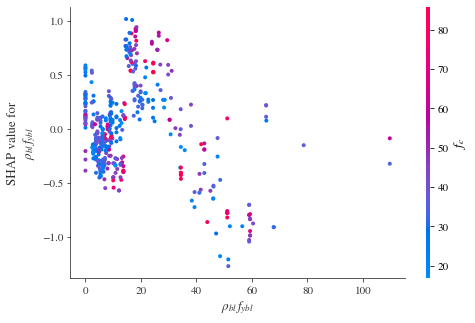

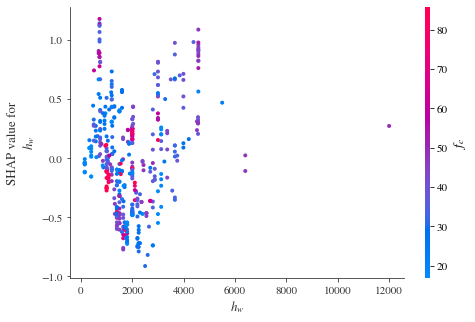

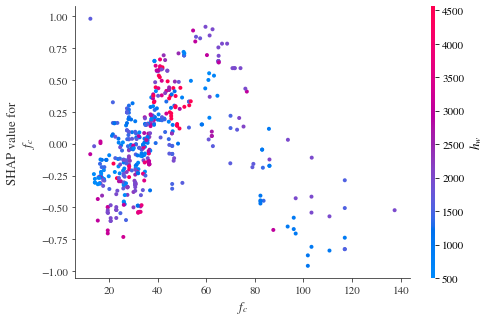

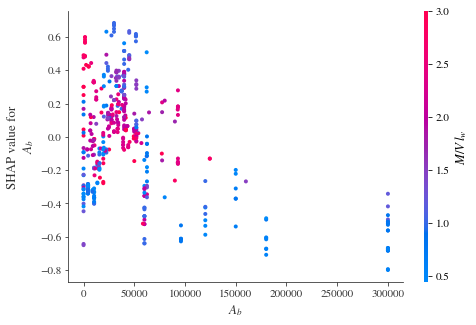

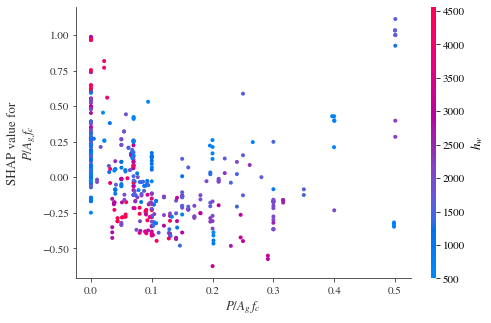

In [63]:
# Dependence plots of the features with respect to shear-flexure failure
for i in range(len(X_new.columns)):
    shap.dependence_plot(ind=i, shap_values=shap_values[1], features=X_new, feature_names=names,)

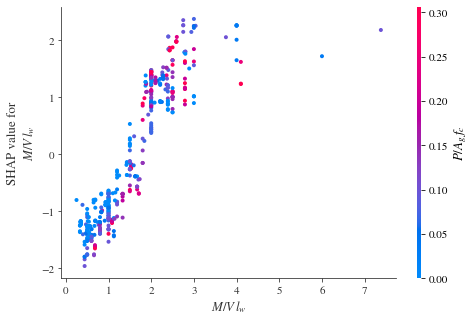

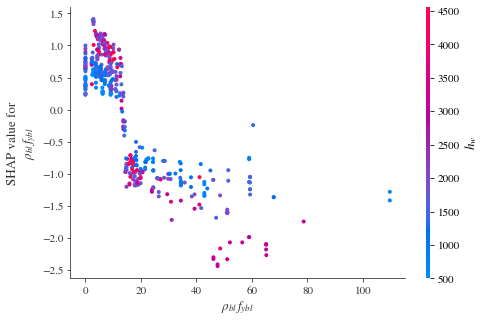

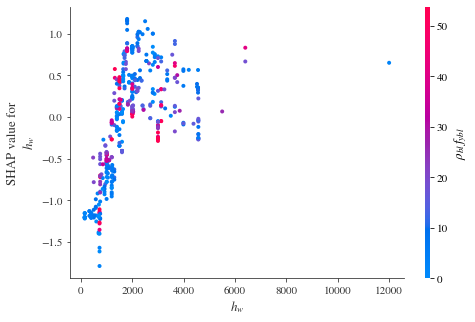

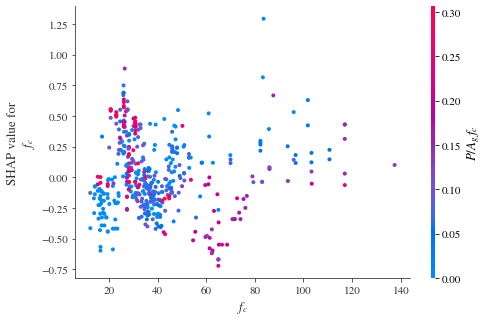

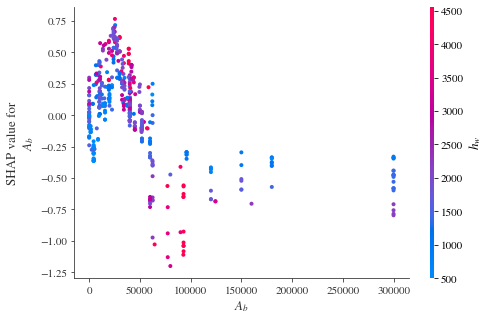

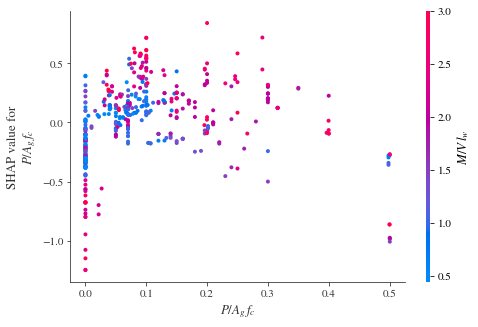

In [64]:
# Dependence plots of the features with respect to shear-flexure failure
for i in range(len(X_new.columns)):
    shap.dependence_plot(ind=i, shap_values=shap_values[2], features=X_new, feature_names=names,)

In [65]:
# Shap explanation based on each specimens for shear failure prediction

for i in range(len(X_test)):
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[0], 
                    explainer.shap_values(X_test.iloc[[i]])[0], 
                    X_test.iloc[i],
                    link="logit"))
    print("Actual failure mode:", np.round(y_test.iloc[i], 2))

Output hidden; open in https://colab.research.google.com to view.

In [66]:
# Shap explanation based on each specimens for shear-flexure failure prediction

for i in range(len(X_test)):
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], 
                    explainer.shap_values(X_test.iloc[[i]])[1], 
                    X_test.iloc[i],
                    link="logit"))
    print("Actual failure mode:", np.round(y_test.iloc[i], 2))

Output hidden; open in https://colab.research.google.com to view.

In [67]:
# Shap explanation based on each specimens for flexure failure prediction

for i in range(len(X_test)):
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[2], 
                    explainer.shap_values(X_test.iloc[[i]])[2], 
                    X_test.iloc[i],
                    link="logit"))
    print("Actual failure mode:", np.round(y_test.iloc[i], 2))

Output hidden; open in https://colab.research.google.com to view.